In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets, Layout, HBox, VBox
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

ModuleNotFoundError: No module named 'ipywidgets'

In [196]:
data = pd.read_csv("UEC.csv", index_col=0)

In [197]:
data['Mid_Price'] = (data['Bids'] + data['Asks']) / 2
data['Spread'] = data['Asks'] - data['Bids']


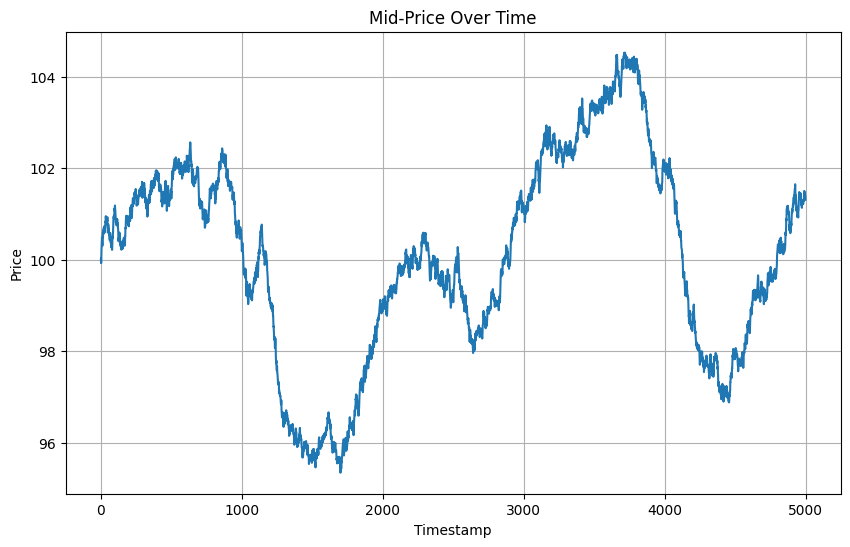

In [198]:
# Plot mid-price
plt.figure(figsize=(10, 6))
plt.plot(data['Mid_Price'])
plt.title('Mid-Price Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.grid(True)
plt.show()

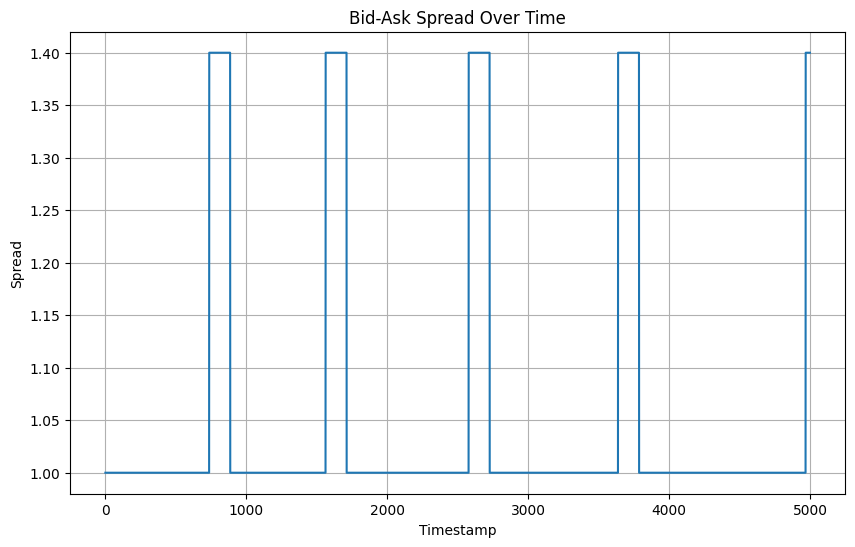

In [199]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Spread'])
plt.title('Bid-Ask Spread Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.grid(True)
plt.show()


Using provided 'UECE.csv' for the example run.
Loaded data with index from column 0 and parsed dates.
Successfully loaded data with 50000 rows.

Data sample (first 5 rows):
        Bids        Asks
0  99.500000  100.500000
1  99.537317  100.537317
2  99.424572  100.424572
3  99.568641  100.568641
4  99.718064  100.718064

Data sample (last 5 rows):
             Bids        Asks
49995  114.135306  115.135306
49996  114.162219  115.162219
49997  114.144824  115.144824
49998  114.132430  115.132430
49999  114.285488  115.285488


/var/folders/dg/gndvkfz564g235vdv95241jw0000gn/T/ipykernel_1891/2395496323.py:338: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
/var/folders/dg/gndvkfz564g235vdv95241jw0000gn/T/ipykernel_1891/2395496323.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  high_spread_shifted = result['In_High_Spread'].shift(1).fillna(False)


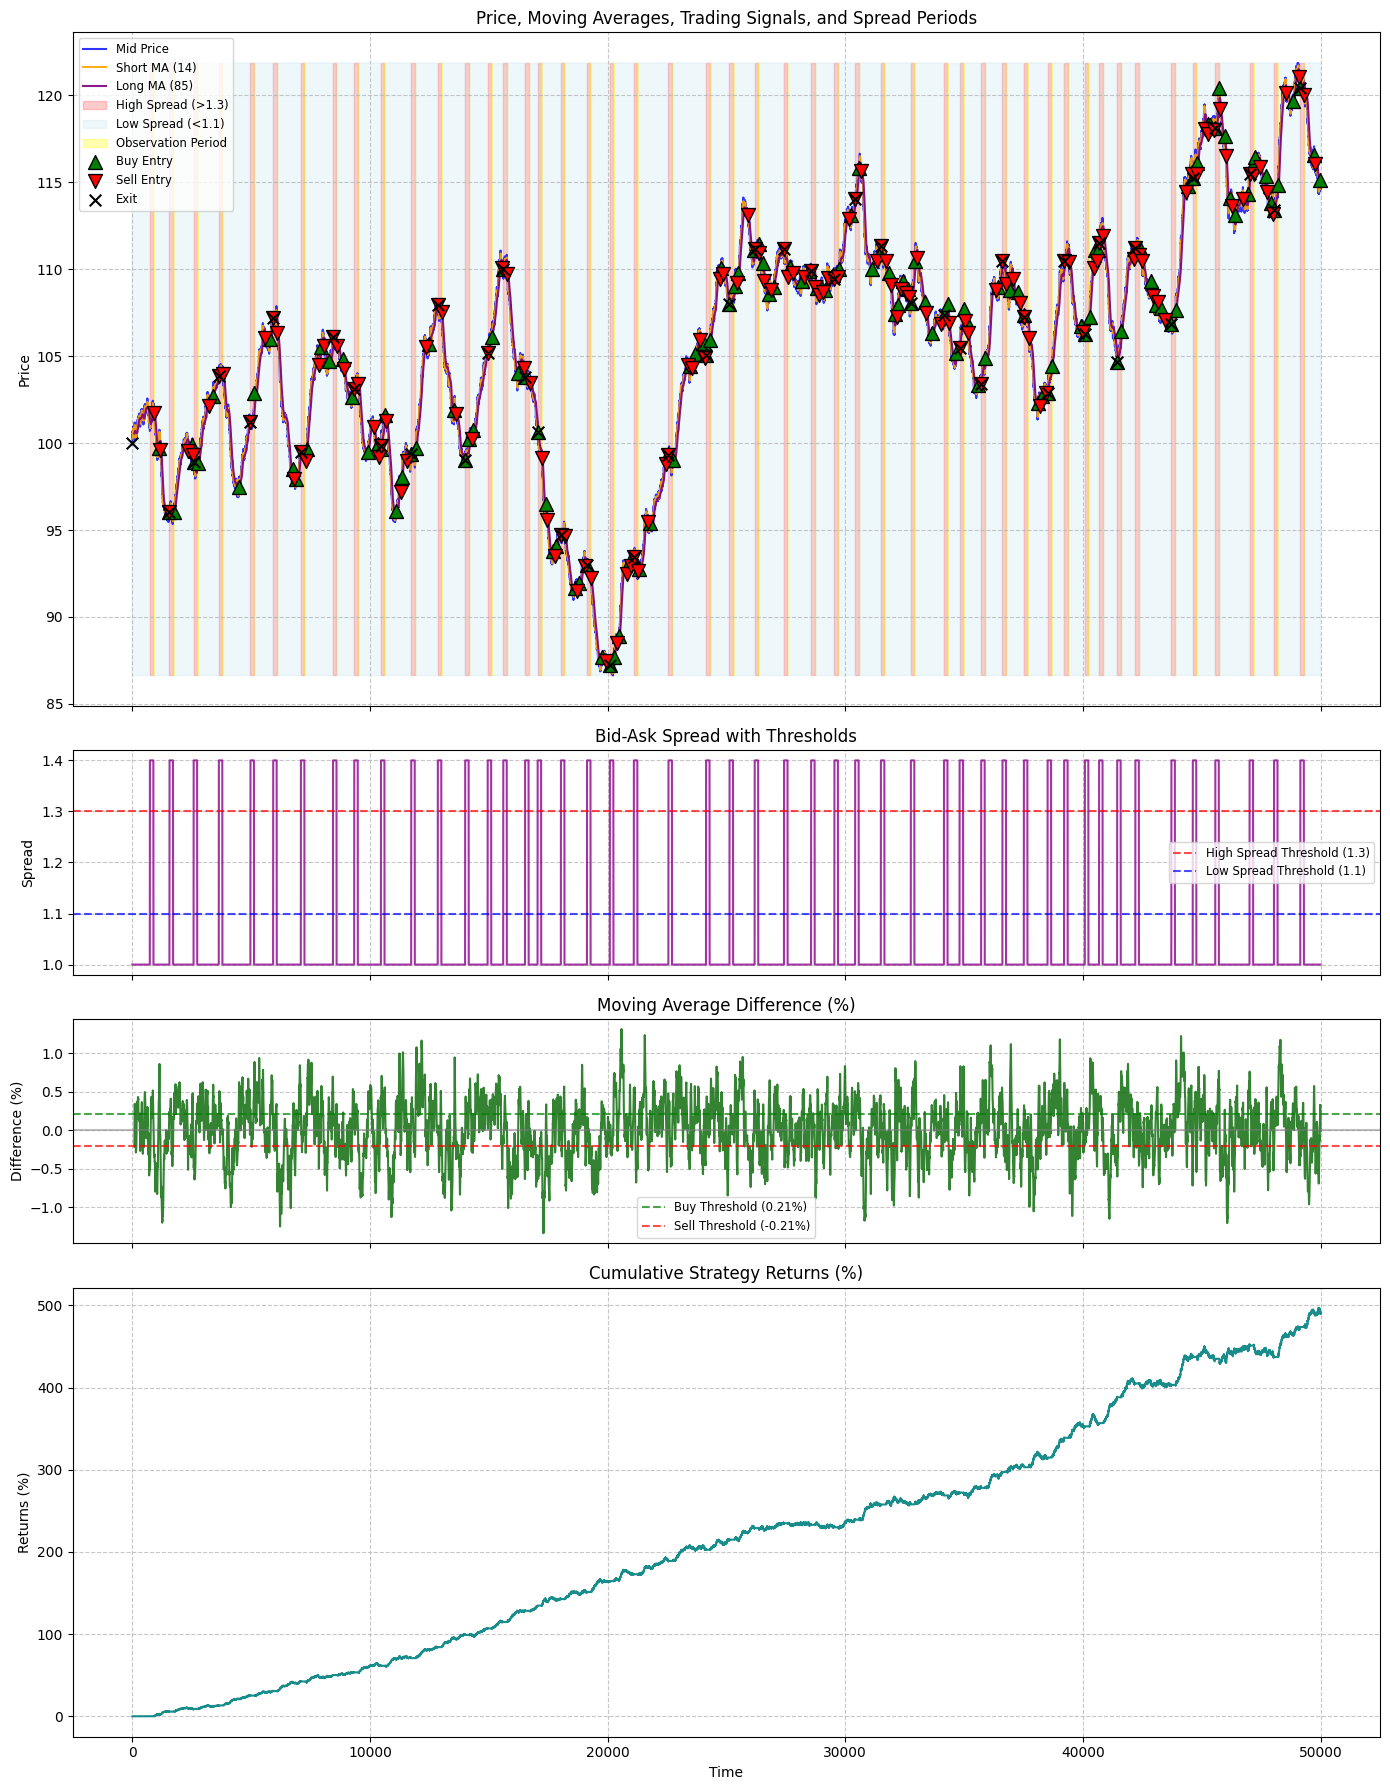


=== Strategy Performance ===
Total Return: 490.66%
Sharpe Ratio (annualized, sqrt(50k)): 12.57
Max Drawdown: -3.85%
Win Rate (Round Trips): 59.57% (28/47)
Total Entries: 48
Total Round Trip Trades Completed: 47
Average Win: 4.35%
Average Loss: -3.62%
Profit Factor: 1.77

Strategy run complete.
Number of rows in result: 50000
Result sample (last 10 rows with relevant columns):
        Mid_Price  Spread  In_High_Spread  In_Low_Spread  Signal  Position  \
49990  114.724987     1.0           False           True       0         1   
49991  114.625233     1.0           False           True       0         1   
49992  114.616769     1.0           False           True       0         1   
49993  114.647633     1.0           False           True       0         1   
49994  114.589630     1.0           False           True       0         1   
49995  114.635306     1.0           False           True       0         1   
49996  114.662219     1.0           False           True       0         1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def spread_ma_strategy(data,
                       high_spread_threshold=1.3, # Threshold for identifying high spread
                       low_spread_threshold=1.1, # Threshold for identifying low spread
                       short_ma_window=20, # Short moving average window
                       long_ma_window=70, # Long moving average window
                       observation_window=30, # Observation window after exiting high spread
                       ma_crossover_threshold=0.3, # Threshold for MA crossover signal (%)
                       plot_results=True # Whether to plot results
                       ):
    """
    Implements a simple spread and moving average trading strategy:
    1. Wait for first high spread period before generating any signals
    2. After exiting high spread, wait for observation window to complete
    3. In low spread periods, take long/short positions based on moving average crossovers
    4. Close all positions when entering high spread periods
    Parameters
    ----------
    data : pandas DataFrame
        DataFrame with 'Bids' and 'Asks' columns
    high_spread_threshold : float
        Threshold to identify high spread state
    low_spread_threshold : float
        Threshold to identify low spread state
    short_ma_window : int
        Window size for short moving average
    long_ma_window : int
        Window size for long moving average
    observation_window : int
        Number of ticks to wait after exiting high spread
    ma_crossover_threshold : float
        Percentage threshold for MA crossover signal
    plot_results : bool
        Whether to plot the strategy results
    Returns
    -------
    DataFrame with strategy results
    """
    # Create a copy to avoid modifying the original
    result = data.copy()

    # Calculate spread and mid price if not already present
    if 'Spread' not in result.columns:
        result['Spread'] = result['Asks'] - result['Bids']
    if 'Mid_Price' not in result.columns:
        result['Mid_Price'] = (result['Asks'] + result['Bids']) / 2

    # Calculate moving averages
    result['Short_MA'] = result['Mid_Price'].rolling(window=short_ma_window).mean()
    result['Long_MA'] = result['Mid_Price'].rolling(window=long_ma_window).mean()

    # Calculate MA difference as percentage
    result['MA_Diff_Pct'] = ((result['Short_MA'] - result['Long_MA']) / result['Long_MA']) * 100

    # Identify spread states
    result['In_High_Spread'] = (result['Spread'] > high_spread_threshold).astype(bool)
    result['In_Low_Spread'] = (result['Spread'] < low_spread_threshold).astype(bool) # Condition for low spread

    # Identify transitions
    high_spread_shifted = result['In_High_Spread'].shift(1).fillna(False)
    result['Exited_High_Spread'] = (high_spread_shifted & ~result['In_High_Spread']).astype(bool)
    result['Entered_High_Spread'] = (~high_spread_shifted & result['In_High_Spread']).astype(bool)

    # Initialize strategy columns
    result['Observation_Period'] = False # Track if we're in observation period
    result['Signal'] = 0 # Trading signal
    result['Position'] = 0 # Current position
    result['Round_ID'] = 0 # Identifier for each trading round

    # Process each row to implement the strategy
    in_observation = False
    observation_counter = 0
    current_position = 0
    round_counter = 0
    has_seen_high_spread = False # Flag to track if we've seen a high spread period

    for i in range(1, len(result)):
        # Check if we're in high spread - set the flag
        if result['In_High_Spread'].iloc[i]:
            has_seen_high_spread = True

        # Skip trading logic until we've seen at least one high spread period
        if not has_seen_high_spread:
            continue

        # Check if we just exited high spread - start observation period
        if result['Exited_High_Spread'].iloc[i]:
            round_counter += 1
            in_observation = True
            observation_counter = 0
            result.loc[result.index[i], 'Observation_Period'] = True
            result.loc[result.index[i], 'Round_ID'] = round_counter
        # Continue observation if we're in that period
        elif in_observation:
            observation_counter += 1
            result.loc[result.index[i], 'Observation_Period'] = True
            result.loc[result.index[i], 'Round_ID'] = round_counter
            # End observation if we've reached the window size
            if observation_counter >= observation_window:
                in_observation = False
        # Check for entry criteria (only if not in observation period and in low spread)
        # The strategy logic uses 'In_Low_Spread' to make trading decisions.
        elif not in_observation and result['In_Low_Spread'].iloc[i]:
            ma_diff = result['MA_Diff_Pct'].iloc[i]
            # Buy signal: Short MA crosses above Long MA by threshold
            if ma_diff > ma_crossover_threshold and current_position <= 0:
                result.loc[result.index[i], 'Signal'] = 1
                current_position = 1
            # Sell signal: Short MA crosses below Long MA by threshold
            elif ma_diff < -ma_crossover_threshold and current_position >= 0:
                result.loc[result.index[i], 'Signal'] = -1
                current_position = -1

        # Check if we just entered high spread - close position
        if result['Entered_High_Spread'].iloc[i] and current_position != 0:
            result.loc[result.index[i], 'Signal'] = -current_position # Close position
            current_position = 0

        # Update position
        result.loc[result.index[i], 'Position'] = current_position
        # Assign round ID if we're in an active round
        if round_counter > 0 and not result['In_High_Spread'].iloc[i]:
            result.loc[result.index[i], 'Round_ID'] = round_counter


    # Calculate returns
    result['Returns'] = result['Mid_Price'].pct_change()
    result['Strategy_Returns'] = result['Position'].shift(1) * result['Returns']
    result['Cumulative_Returns'] = (1 + result['Strategy_Returns']).cumprod() - 1

    # Plot results if requested
    if plot_results:
        # Corrected to pass short_ma_window and long_ma_window
        plot_strategy_results(result, ma_crossover_threshold, high_spread_threshold, low_spread_threshold, short_ma_window, long_ma_window)
        print_performance_metrics(result)

    return result

def plot_strategy_results(result, ma_crossover_threshold=0.3, high_spread_threshold=1.3, low_spread_threshold=1.1, short_ma_window=20, long_ma_window=70):
    """
    Visualize the trading strategy results, highlighting high and low spread periods.
    Parameters
    ----------
    result : pandas DataFrame
        The strategy results DataFrame
    ma_crossover_threshold : float
        The MA crossover threshold used in the strategy
    high_spread_threshold : float
        Threshold used to identify high spread state for plotting reference
    low_spread_threshold : float
        Threshold used to identify low spread state for plotting reference
    short_ma_window : int
        Window size for short moving average (for labeling)
    long_ma_window : int
        Window size for long moving average (for labeling)
    """
    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True, # Increased figure height
                           gridspec_kw={'height_ratios': [3, 1, 1, 2]})

    # Plot 1: Price and MAs with spread highlighting
    ax1 = axes[0]
    ax1.plot(result.index, result['Mid_Price'], 'b-', label='Mid Price', alpha=0.8)
    ax1.plot(result.index, result['Short_MA'], 'orange', label=f'Short MA ({short_ma_window})', alpha=0.9)
    ax1.plot(result.index, result['Long_MA'], 'purple', label=f'Long MA ({long_ma_window})', alpha=0.9)


    # Highlight high spread regions
    high_spread_regions = result['In_High_Spread']
    ax1.fill_between(result.index, result['Mid_Price'].min(), result['Mid_Price'].max(),
                     where=high_spread_regions, alpha=0.2, color='red', label=f'High Spread (>{high_spread_threshold})')

    # Highlight low spread regions
    low_spread_regions_for_plot = result['In_Low_Spread']
    # Optional: Prevent overplotting low spread on high spread if they could overlap due to thresholds
    # For instance, if low_spread_threshold > high_spread_threshold, which is not typical.
    # Or if you want low spread to only show when *not* in high spread or observation.
    # For this visualization, direct plotting with transparency is usually sufficient.
    # low_spread_regions_for_plot = result['In_Low_Spread'] & ~result['In_High_Spread'] & ~result['Observation_Period']
    ax1.fill_between(result.index, result['Mid_Price'].min(), result['Mid_Price'].max(),
                     where=low_spread_regions_for_plot, alpha=0.2, color='lightblue', label=f'Low Spread (<{low_spread_threshold})') # Changed color


    # Mark observation periods
    observation_periods = result['Observation_Period']
    ax1.fill_between(result.index, result['Mid_Price'].min(), result['Mid_Price'].max(),
                     where=observation_periods, alpha=0.3, color='yellow', label='Observation Period')

    # Add buy/sell signals
    buy_signals = result[result['Signal'] == 1]
    sell_signals = result[result['Signal'] == -1]

    ax1.scatter(buy_signals.index, buy_signals['Mid_Price'], marker='^', color='green', s=100, label='Buy Entry', edgecolor='black', zorder=5)
    ax1.scatter(sell_signals.index, sell_signals['Mid_Price'], marker='v', color='red', s=100, label='Sell Entry', edgecolor='black', zorder=5)

    # Mark exits (when position goes to 0 from non-zero, or a reversing signal occurs)
    exits = result[ (result['Position'].shift(1) != 0) & (result['Position'] == 0) ]
    ax1.scatter(exits.index, exits['Mid_Price'], marker='x', color='black', s=70, label='Exit', zorder=5)


    ax1.set_title('Price, Moving Averages, Trading Signals, and Spread Periods')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left', fontsize='small')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Spread
    ax2 = axes[1]
    ax2.plot(result.index, result['Spread'], 'darkmagenta', alpha=0.8) # Changed color
    ax2.axhline(y=high_spread_threshold, color='red', linestyle='--', alpha=0.7, label=f'High Spread Threshold ({high_spread_threshold})')
    ax2.axhline(y=low_spread_threshold, color='blue', linestyle='--', alpha=0.7, label=f'Low Spread Threshold ({low_spread_threshold})')
    ax2.set_title('Bid-Ask Spread with Thresholds')
    ax2.set_ylabel('Spread')
    ax2.legend(fontsize='small')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Moving Average Difference
    ax3 = axes[2]
    ax3.plot(result.index, result['MA_Diff_Pct'], 'darkgreen', alpha=0.8) # Changed color
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax3.axhline(y=ma_crossover_threshold, color='green', linestyle='--', alpha=0.7, label=f'Buy Threshold ({ma_crossover_threshold}%)')
    ax3.axhline(y=-ma_crossover_threshold, color='red', linestyle='--', alpha=0.7, label=f'Sell Threshold ({-ma_crossover_threshold}%)')
    ax3.set_title('Moving Average Difference (%)')
    ax3.set_ylabel('Difference (%)')
    ax3.legend(fontsize='small')
    ax3.grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Cumulative Returns
    ax4 = axes[3]
    ax4.plot(result.index, result['Cumulative_Returns'] * 100, 'teal', alpha=0.9) # Changed color
    ax4.set_title('Cumulative Strategy Returns (%)')
    ax4.set_ylabel('Returns (%)')
    ax4.set_xlabel('Time')
    ax4.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def print_performance_metrics(result):
    """
    Print performance metrics for the strategy
    """
    # Calculate metrics
    total_return = result['Cumulative_Returns'].iloc[-1] * 100 if not result['Cumulative_Returns'].empty else 0

    strategy_returns = result['Strategy_Returns'].dropna()
    if not strategy_returns.empty and strategy_returns.std() > 0:
        # Using a common annualization factor for daily returns (sqrt(252))
        # If data is higher frequency, this factor needs adjustment or use non-annualized.
        # The original code used sqrt(50000), let's stick to that for consistency if it was intended for the data frequency.
        sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(50000)
    else:
        sharpe = 0

    # Calculate win rate based on round trips
    trade_returns_list = []
    current_pos_val = 0 # Using result['Position'] for more robust state tracking
    entry_price = 0.0

    # Iterate through the results to identify trades and calculate their returns
    for i in range(len(result)):
        position_now = result['Position'].iloc[i]
        position_prev = result['Position'].iloc[i-1] if i > 0 else 0
        mid_price = result['Mid_Price'].iloc[i]

        # Entry
        if position_now != 0 and position_prev == 0: # Entered a new position
            entry_price = mid_price
            current_pos_val = position_now # Store the direction of position (1 for long, -1 for short)

        # Exit
        elif position_now == 0 and position_prev != 0: # Exited a position
            if entry_price != 0: # Ensure there was an entry
                if position_prev == 1: # Exited a long position
                    trade_return = (mid_price / entry_price - 1)
                elif position_prev == -1: # Exited a short position
                    trade_return = (entry_price / mid_price - 1)
                else: # Should not happen if logic is correct
                    trade_return = 0
                trade_returns_list.append(trade_return)
                entry_price = 0 # Reset entry price
                current_pos_val = 0 # Reset position

    num_round_trip_trades = len(trade_returns_list)
    winning_trades = sum(1 for ret in trade_returns_list if ret > 0)
    win_rate = winning_trades / num_round_trip_trades if num_round_trip_trades > 0 else 0
    
    actual_entries = result[(result['Position'] != 0) & (result['Position'].shift(1) == 0)].shape[0]


    # Calculate max drawdown
    if not result['Cumulative_Returns'].empty:
        # Cumulative returns are already 0-based percentages (e.g., 0.01 for 1%)
        # To calculate drawdown, we work with the equity curve (1 + cumulative returns)
        equity_curve = 1 + result['Cumulative_Returns']
        running_max = equity_curve.cummax()
        drawdown = (equity_curve - running_max) / running_max # Drawdown as percentage from peak
        max_drawdown = drawdown.min() * 100 if not drawdown.empty else 0
    else:
        max_drawdown = 0


    print("\n=== Strategy Performance ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio (annualized, sqrt(50k)): {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Win Rate (Round Trips): {win_rate*100:.2f}% ({winning_trades}/{num_round_trip_trades})")
    print(f"Total Entries: {actual_entries}") # More direct count of entries
    print(f"Total Round Trip Trades Completed: {num_round_trip_trades}")


    if trade_returns_list:
        avg_win = np.mean([ret for ret in trade_returns_list if ret > 0]) * 100 if any(ret > 0 for ret in trade_returns_list) else 0
        # Losses are negative, so avg_loss will be negative. Multiplied by 100 for percentage.
        avg_loss = np.mean([ret for ret in trade_returns_list if ret < 0]) * 100 if any(ret < 0 for ret in trade_returns_list) else 0
        
        sum_gains = sum(ret for ret in trade_returns_list if ret > 0)
        sum_losses_abs = abs(sum(ret for ret in trade_returns_list if ret < 0)) # Absolute sum of losses
        
        profit_factor = sum_gains / sum_losses_abs if sum_losses_abs > 0 else float('inf') # Ensure positive factor
        
        print(f"Average Win: {avg_win:.2f}%")
        print(f"Average Loss: {avg_loss:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")
    else:
        print("No round trip trades executed to calculate detailed trade metrics.")


def run_strategy_from_csv(csv_path, **kwargs):
    """
    Load data from CSV and run the strategy
    """
    try:
        # Try to load with index column first, and parse dates
        try:
            data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
            print(f"Loaded data with index from column 0 and parsed dates.")
        except Exception as e1:
            print(f"Failed to load with index_col=0 or parse dates directly: {e1}. Trying alternatives.")
            # If that fails, load without specifying index column but still try to parse common date columns
            data = pd.read_csv(csv_path)
            parsed_date_index = False
            for col_name in ['Timestamp', 'time', 'Date', 'Datetime']: # Common date column names
                if col_name in data.columns:
                    try:
                        data[col_name] = pd.to_datetime(data[col_name])
                        data.set_index(col_name, inplace=True)
                        print(f"Successfully parsed '{col_name}' as datetime and set as index.")
                        parsed_date_index = True
                        break
                    except Exception as e2:
                        print(f"Could not parse column '{col_name}' as datetime or set as index: {e2}")
            if not parsed_date_index:
                print("Warning: Could not automatically parse a date column and set it as index. Using default integer index.")


        print(f"Successfully loaded data with {len(data)} rows.")

        # Check if required columns exist
        required_cols = ['Bids', 'Asks']
        if not all(col in data.columns for col in required_cols):
            print(f"Warning: Missing one or more required columns: {required_cols}. Attempting to infer.")
            
            numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
            if len(numeric_cols) >= 2:
                print(f"Using first two numeric columns '{numeric_cols[0]}' and '{numeric_cols[1]}' as Bids and Asks.")
                data = data.rename(columns={numeric_cols[0]: 'Bids', numeric_cols[1]: 'Asks'})
            else: # Try to convert
                converted_cols_map = {}
                for col_idx, col_name_original in enumerate(data.columns):
                    if len(converted_cols_map) == 2: break # Found two suitable columns
                    try:
                        data[col_name_original] = pd.to_numeric(data[col_name_original], errors='raise')
                        if 'Bids' not in converted_cols_map:
                            converted_cols_map['Bids'] = col_name_original
                        elif 'Asks' not in converted_cols_map:
                            converted_cols_map['Asks'] = col_name_original
                    except (ValueError, TypeError):
                        pass # Column is not numeric or convertible

                if 'Bids' in converted_cols_map and 'Asks' in converted_cols_map:
                    print(f"Converted and using '{converted_cols_map['Bids']}' as Bids and '{converted_cols_map['Asks']}' as Asks.")
                    data = data.rename(columns={converted_cols_map['Bids']: 'Bids', converted_cols_map['Asks']: 'Asks'})
                else:
                    raise ValueError(f"Could not find or convert suitable numeric columns for Bids and Asks. Found: {list(converted_cols_map.values())}")

        # Ensure Bids and Asks are numeric and handle NaNs
        for col in ['Bids', 'Asks']:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        
        initial_rows = len(data)
        data.dropna(subset=['Bids', 'Asks'], inplace=True)
        if len(data) < initial_rows:
            print(f"Dropped {initial_rows - len(data)} rows due to non-numeric Bids/Asks values.")

        if data.empty:
            raise ValueError("Data is empty after attempting to load and process Bids/Asks columns.")

        # Print data sample
        print("\nData sample (first 5 rows):")
        print(data.head())
        print("\nData sample (last 5 rows):")
        print(data.tail())


        # Run the strategy
        result_df = spread_ma_strategy(data, **kwargs)
        return result_df
    except FileNotFoundError:
        print(f"Error: The file '{csv_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while running the strategy: {e}")
        import traceback
        traceback.print_exc()
        return None

# --- Example Usage ---
# Create a dummy CSV for testing if 'UECE.csv' is not available
try:
    # Attempt to load the specified UECE.csv first
    pd.read_csv('UEC.csv', nrows=1) # Check if file exists and is readable
    csv_to_use = 'UEC.csv'
    print(f"Using provided 'UECE.csv' for the example run.")
except FileNotFoundError:
    print("'UECE.csv' not found. Creating and using 'UECE_dummy.csv' for demonstration.")
    dummy_data = {
        'Timestamp': pd.to_datetime(pd.date_range(start='2023-01-01 09:00', periods=1000, freq='1min')), # 1000 minutes
        'Bids': 1000 + np.cumsum(np.random.normal(0, 0.5, 1000)), # Simulating some price movement
    }
    # Ensure bids don't go negative or too low
    dummy_data['Bids'] = np.maximum(10, dummy_data['Bids'])
    # Create asks with a variable spread
    base_spread = np.random.uniform(0.8, 1.5, 1000) # Normal spread
    high_spread_indices = np.random.choice(1000, size=100, replace=False) # 10% of data with high spread
    base_spread[high_spread_indices] = np.random.uniform(1.5, 3.0) # High spread values
    dummy_data['Asks'] = dummy_data['Bids'] + base_spread
    
    df_dummy = pd.DataFrame(dummy_data)
    df_dummy.to_csv('UECE_dummy.csv', index=False) # Save dummy CSV
    csv_to_use = 'UECE_dummy.csv'


# Run the strategy with the chosen CSV
result_output_df = run_strategy_from_csv(
    csv_to_use,
    high_spread_threshold=1.3,
    low_spread_threshold=1.1,
    short_ma_window=14,
    long_ma_window=85,
    observation_window=21,
    ma_crossover_threshold=0.21,
    plot_results=True
)

if result_output_df is not None:
    print("\nStrategy run complete.")
    print(f"Number of rows in result: {len(result_output_df)}")
    print("Result sample (last 10 rows with relevant columns):")
    print(result_output_df[['Mid_Price', 'Spread', 'In_High_Spread', 'In_Low_Spread', 'Signal', 'Position', 'Cumulative_Returns']].tail(10))
else:
    print("\nStrategy run failed or produced no results.")

Attempting to analyze spread periods for: UEC.csv
Loaded data from 'UEC.csv' with index from column 0 and parsed dates.
Successfully loaded 50000 rows from 'UEC.csv'.

Data sample (first 5 rows):
        Bids        Asks
0  99.500000  100.500000
1  99.537317  100.537317
2  99.424572  100.424572
3  99.568641  100.568641
4  99.718064  100.718064


/var/folders/dg/gndvkfz564g235vdv95241jw0000gn/T/ipykernel_1891/324950574.py:121: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(csv_path, index_col=0, parse_dates=True)


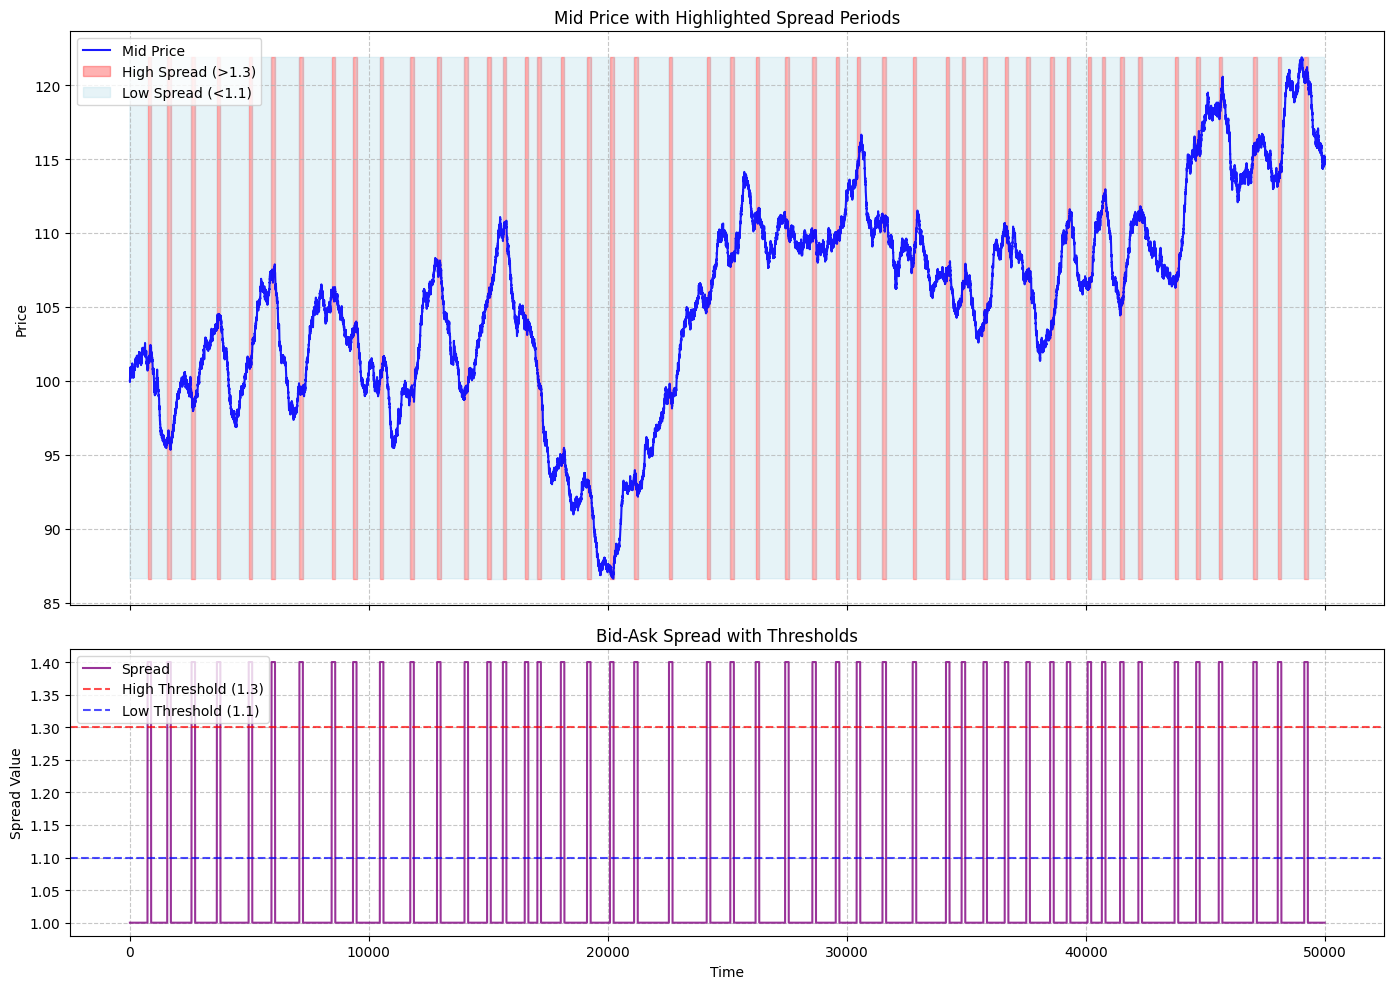


Spread analysis complete.
Result sample (last 5 rows with spread info):
             Bids        Asks   Mid_Price  Spread  In_High_Spread  \
49995  114.135306  115.135306  114.635306     1.0           False   
49996  114.162219  115.162219  114.662219     1.0           False   
49997  114.144824  115.144824  114.644824     1.0           False   
49998  114.132430  115.132430  114.632430     1.0           False   
49999  114.285488  115.285488  114.785488     1.0           False   

       In_Low_Spread  
49995           True  
49996           True  
49997           True  
49998           True  
49999           True  

Successfully processed 'UEC.csv'. Check the plot.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def identify_spread_periods(data,
                            high_spread_threshold=1.3,
                            low_spread_threshold=1.1,
                            plot_results=True):
    """
    Identifies and optionally plots periods of high and low spread.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame with 'Bids' and 'Asks' columns.
    high_spread_threshold : float
        Threshold to identify high spread state.
    low_spread_threshold : float
        Threshold to identify low spread state.
    plot_results : bool
        Whether to plot the results.

    Returns
    -------
    pandas.DataFrame
        DataFrame with 'Spread', 'Mid_Price', 'In_High_Spread', 
        and 'In_Low_Spread' columns.
    """
    result = data.copy()

    # Ensure 'Bids' and 'Asks' are numeric
    if 'Bids' in result.columns and 'Asks' in result.columns:
        result['Bids'] = pd.to_numeric(result['Bids'], errors='coerce')
        result['Asks'] = pd.to_numeric(result['Asks'], errors='coerce')
        result.dropna(subset=['Bids', 'Asks'], inplace=True) # Drop rows where conversion failed
    else:
        raise ValueError("DataFrame must contain 'Bids' and 'Asks' columns.")

    if result.empty:
        print("Warning: Data is empty after processing Bids/Asks. Cannot proceed.")
        return result
        
    # Calculate spread and mid price
    result['Spread'] = result['Asks'] - result['Bids']
    result['Mid_Price'] = (result['Asks'] + result['Bids']) / 2

    # Identify spread states
    result['In_High_Spread'] = (result['Spread'] > high_spread_threshold)
    result['In_Low_Spread'] = (result['Spread'] < low_spread_threshold)

    if plot_results:
        plot_spread_highlights(result, high_spread_threshold, low_spread_threshold)

    return result

def plot_spread_highlights(result_data, high_spread_threshold, low_spread_threshold):
    """
    Visualizes the mid-price with highlighted high and low spread periods.
    Also plots the spread itself with thresholds.

    Parameters
    ----------
    result_data : pandas.DataFrame
        DataFrame containing 'Mid_Price', 'Spread', 'In_High_Spread', 
        'In_Low_Spread' columns.
    high_spread_threshold : float
        Threshold for identifying high spread state.
    low_spread_threshold : float
        Threshold for identifying low spread state.
    """
    if result_data.empty or 'Mid_Price' not in result_data.columns:
        print("No data to plot or 'Mid_Price' column missing.")
        return

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

    # Plot 1: Price with spread period highlighting
    ax1 = axes[0]
    ax1.plot(result_data.index, result_data['Mid_Price'], 'b-', label='Mid Price', alpha=0.9)

    # Highlight high spread regions
    ax1.fill_between(result_data.index, result_data['Mid_Price'].min(), result_data['Mid_Price'].max(),
                     where=result_data['In_High_Spread'], alpha=0.3, color='red', label=f'High Spread (>{high_spread_threshold})')

    # Highlight low spread regions
    # To avoid overplotting if thresholds are weird or data makes it overlap,
    # you can add conditions like `& ~result_data['In_High_Spread']`
    ax1.fill_between(result_data.index, result_data['Mid_Price'].min(), result_data['Mid_Price'].max(),
                     where=result_data['In_Low_Spread'], alpha=0.3, color='lightblue', label=f'Low Spread (<{low_spread_threshold})')

    ax1.set_title('Mid Price with Highlighted Spread Periods')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Spread itself with thresholds
    ax2 = axes[1]
    ax2.plot(result_data.index, result_data['Spread'], 'purple', label='Spread', alpha=0.8)
    ax2.axhline(y=high_spread_threshold, color='red', linestyle='--', alpha=0.7, label=f'High Threshold ({high_spread_threshold})')
    ax2.axhline(y=low_spread_threshold, color='blue', linestyle='--', alpha=0.7, label=f'Low Threshold ({low_spread_threshold})')
    
    ax2.set_title('Bid-Ask Spread with Thresholds')
    ax2.set_ylabel('Spread Value')
    ax2.set_xlabel('Time')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def run_spread_analysis_from_csv(csv_path,
                                 high_spread_threshold=1.3,
                                 low_spread_threshold=1.1):
    """
    Loads data from a CSV, identifies spread periods, and plots them.
    """
    try:
        # Try to load with index column first, and parse dates
        try:
            data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
            print(f"Loaded data from '{csv_path}' with index from column 0 and parsed dates.")
        except Exception as e1:
            print(f"Failed to load '{csv_path}' with index_col=0 or parse dates directly: {e1}. Trying alternatives.")
            data = pd.read_csv(csv_path)
            parsed_date_index = False
            # Common date/time column names
            for col_name in ['Timestamp', 'timestamp', 'Time', 'time', 'Date', 'date', 'Datetime', 'datetime']:
                if col_name in data.columns:
                    try:
                        data[col_name] = pd.to_datetime(data[col_name])
                        data.set_index(col_name, inplace=True)
                        print(f"Successfully parsed '{col_name}' as datetime and set as index for '{csv_path}'.")
                        parsed_date_index = True
                        break
                    except Exception as e2:
                        print(f"Could not parse column '{col_name}' as datetime or set as index from '{csv_path}': {e2}")
            if not parsed_date_index:
                print(f"Warning: Could not automatically parse a date column and set it as index for '{csv_path}'. Using default integer index.")

        print(f"Successfully loaded {len(data)} rows from '{csv_path}'.")

        # Check if required columns exist, infer if necessary
        required_cols = ['Bids', 'Asks']
        if not all(col in data.columns for col in required_cols):
            print(f"Warning: Missing one or more required columns: {required_cols} in '{csv_path}'. Attempting to infer.")
            
            # Attempt to use the first two columns if they are numeric
            # Or, more robustly, find the first two numeric columns
            numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
            if len(numeric_cols) >= 2:
                print(f"Using first two numeric columns '{numeric_cols[0]}' and '{numeric_cols[1]}' as Bids and Asks from '{csv_path}'.")
                data = data.rename(columns={numeric_cols[0]: 'Bids', numeric_cols[1]: 'Asks'})
            else: # Try to convert
                converted_cols_map = {}
                potential_bid_ask_cols = [col for col in data.columns if col.lower() in ['bid','bids','ask','asks']]
                
                if len(potential_bid_ask_cols) == 2:
                     # Simple case: found 'bid' and 'ask' like columns
                    bid_col_name = next((c for c in potential_bid_ask_cols if 'bid' in c.lower()), None)
                    ask_col_name = next((c for c in potential_bid_ask_cols if 'ask' in c.lower()), None)
                    if bid_col_name and ask_col_name:
                        print(f"Found columns '{bid_col_name}' and '{ask_col_name}'. Attempting to use them as Bids and Asks.")
                        data = data.rename(columns={bid_col_name: 'Bids', ask_col_name: 'Asks'})


                if not ('Bids' in data.columns and 'Asks' in data.columns): # If renaming didn't work or wasn't applicable
                    # Fallback to converting any two columns if desperate
                    for col_idx, col_name_original in enumerate(data.columns):
                        if len(converted_cols_map) == 2: break
                        try:
                            # Test conversion without permanent change first
                            pd.to_numeric(data[col_name_original], errors='raise')
                            if 'Bids' not in converted_cols_map:
                                converted_cols_map['Bids_temp'] = col_name_original
                            elif 'Asks' not in converted_cols_map:
                                converted_cols_map['Asks_temp'] = col_name_original
                        except (ValueError, TypeError):
                            pass
                    
                    if 'Bids_temp' in converted_cols_map and 'Asks_temp' in converted_cols_map:
                        b_col = converted_cols_map['Bids_temp']
                        a_col = converted_cols_map['Asks_temp']
                        print(f"Attempting to convert and use '{b_col}' as Bids and '{a_col}' as Asks from '{csv_path}'.")
                        data = data.rename(columns={b_col: 'Bids', a_col: 'Asks'})
                    else:
                         raise ValueError(f"Could not find or convert suitable numeric columns for Bids and Asks in '{csv_path}'. Please ensure 'Bids' and 'Asks' columns are present or clearly identifiable.")

        # Final check and processing
        if 'Bids' not in data.columns or 'Asks' not in data.columns:
             raise ValueError(f"Failed to identify 'Bids' and 'Asks' columns in '{csv_path}'.")

        print("\nData sample (first 5 rows):")
        print(data.head())

        # Identify and plot spread periods
        processed_data = identify_spread_periods(data,
                                                 high_spread_threshold=high_spread_threshold,
                                                 low_spread_threshold=low_spread_threshold,
                                                 plot_results=True)
        
        if not processed_data.empty:
            print("\nSpread analysis complete.")
            print("Result sample (last 5 rows with spread info):")
            print(processed_data[['Bids', 'Asks', 'Mid_Price', 'Spread', 'In_High_Spread', 'In_Low_Spread']].tail())
        else:
            print("\nSpread analysis resulted in empty data. Check input file and column names.")
            
        return processed_data

    except FileNotFoundError:
        print(f"Error: The file '{csv_path}' was not found. Please check the file path.")
        return None
    except ValueError as ve:
        print(f"ValueError during processing: {ve}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing '{csv_path}': {e}")
        import traceback
        traceback.print_exc()
        return None

# --- Example Usage ---
# This will attempt to use 'UECE.csv'.
# Make sure 'UECE.csv' is in the same directory as the script,
# or provide the full path to the file.
csv_file_path = 'UEC.csv' 

print(f"Attempting to analyze spread periods for: {csv_file_path}")
results = run_spread_analysis_from_csv(
    csv_file_path,
    high_spread_threshold=1.3, # Define your high spread threshold
    low_spread_threshold=1.1   # Define your low spread threshold
)

if results is None:
    print(f"\nAnalysis for '{csv_file_path}' failed or the file was not found.")
elif results.empty:
    print(f"\nAnalysis for '{csv_file_path}' completed but resulted in no data to show (e.g., all rows dropped).")
else:
    print(f"\nSuccessfully processed '{csv_file_path}'. Check the plot.")

Successfully loaded data with 50000 rows

Data sample:
        Bids        Asks
0  99.500000  100.500000
1  99.537317  100.537317
2  99.424572  100.424572
3  99.568641  100.568641
4  99.718064  100.718064


/var/folders/dg/gndvkfz564g235vdv95241jw0000gn/T/ipykernel_88830/1925787078.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  high_spread_shifted = result['In_High_Spread'].shift(1).fillna(False)


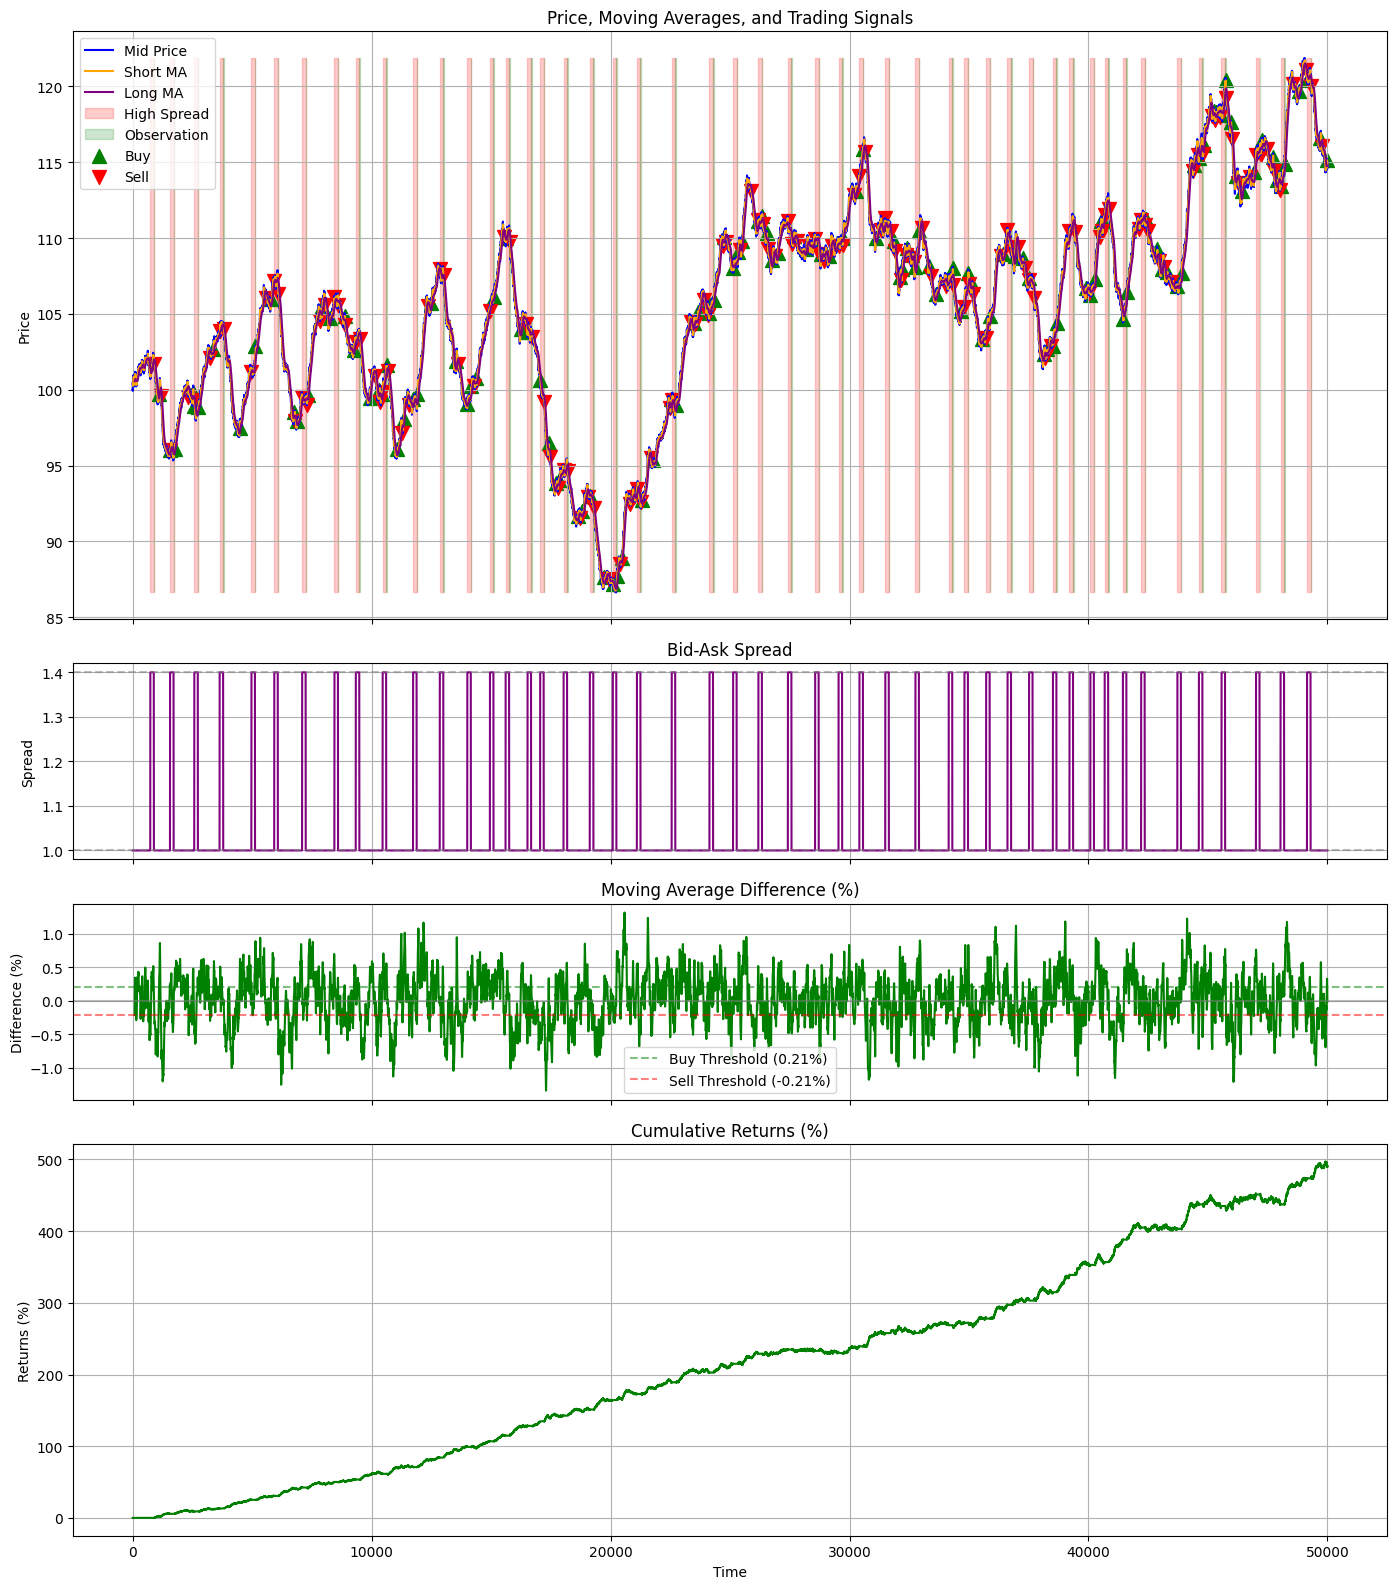

=== Strategy Performance ===
Total Return: 490.66%
Sharpe Ratio: 12.57
Max Drawdown: -3.85%
Win Rate: 60.14% (86/143)
Total Trades: 275
Average Win: 1.80%
Average Loss: -0.55%
Profit Factor: 4.92


In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def spread_ma_strategy(data, 
                       high_spread_threshold=1.3,  # Threshold for identifying high spread
                       low_spread_threshold=1.1,   # Threshold for identifying low spread
                       short_ma_window=20,         # Short moving average window
                       long_ma_window=70,          # Long moving average window
                       observation_window=30,      # Observation window after exiting high spread
                       ma_crossover_threshold=0.3, # Threshold for MA crossover signal (%)
                       plot_results=True           # Whether to plot results
                      ):
    """
    Implements a simple spread and moving average trading strategy:
    
    1. Wait for first high spread period before generating any signals
    2. After exiting high spread, wait for observation window to complete
    3. In low spread periods, take long/short positions based on moving average crossovers
    4. Close all positions when entering high spread periods
    
    Parameters
    ----------
    data : pandas DataFrame
        DataFrame with 'Bids' and 'Asks' columns
    high_spread_threshold : float
        Threshold to identify high spread state
    low_spread_threshold : float
        Threshold to identify low spread state
    short_ma_window : int
        Window size for short moving average
    long_ma_window : int
        Window size for long moving average
    observation_window : int
        Number of ticks to wait after exiting high spread
    ma_crossover_threshold : float
        Percentage threshold for MA crossover signal
    plot_results : bool
        Whether to plot the strategy results
        
    Returns
    -------
    DataFrame with strategy results
    """
    # Create a copy to avoid modifying the original
    result = data.copy()
    
    # Calculate spread and mid price if not already present
    if 'Spread' not in result.columns:
        result['Spread'] = result['Asks'] - result['Bids']
    if 'Mid_Price' not in result.columns:
        result['Mid_Price'] = (result['Asks'] + result['Bids']) / 2
    
    # Calculate moving averages
    result['Short_MA'] = result['Mid_Price'].rolling(window=short_ma_window).mean()
    result['Long_MA'] = result['Mid_Price'].rolling(window=long_ma_window).mean()
    
    # Calculate MA difference as percentage
    result['MA_Diff_Pct'] = ((result['Short_MA'] - result['Long_MA']) / result['Long_MA']) * 100
    
    # Identify spread states
    result['In_High_Spread'] = (result['Spread'] > high_spread_threshold).astype(bool)
    result['In_Low_Spread'] = (result['Spread'] < low_spread_threshold).astype(bool)
    
    # Identify transitions
    high_spread_shifted = result['In_High_Spread'].shift(1).fillna(False)
    result['Exited_High_Spread'] = (high_spread_shifted & ~result['In_High_Spread']).astype(bool)
    result['Entered_High_Spread'] = (~high_spread_shifted & result['In_High_Spread']).astype(bool)
    
    # Initialize strategy columns
    result['Observation_Period'] = False  # Track if we're in observation period
    result['Signal'] = 0                  # Trading signal
    result['Position'] = 0                # Current position
    result['Round_ID'] = 0                # Identifier for each trading round
    
    # Process each row to implement the strategy
    in_observation = False
    observation_counter = 0
    current_position = 0
    round_counter = 0
    has_seen_high_spread = False  # Flag to track if we've seen a high spread period
    
    for i in range(1, len(result)):
        # Check if we're in high spread - set the flag
        if result['In_High_Spread'].iloc[i]:
            has_seen_high_spread = True
        
        # Skip trading logic until we've seen at least one high spread period
        if not has_seen_high_spread:
            continue
        
        # Check if we just exited high spread - start observation period
        if result['Exited_High_Spread'].iloc[i]:
            round_counter += 1
            in_observation = True
            observation_counter = 0
            result.loc[result.index[i], 'Observation_Period'] = True
            result.loc[result.index[i], 'Round_ID'] = round_counter
            
        # Continue observation if we're in that period
        elif in_observation:
            observation_counter += 1
            result.loc[result.index[i], 'Observation_Period'] = True
            result.loc[result.index[i], 'Round_ID'] = round_counter
            
            # End observation if we've reached the window size
            if observation_counter >= observation_window:
                in_observation = False
            
        # Check for entry criteria (only if not in observation period and in low spread)
        elif not in_observation and result['In_Low_Spread'].iloc[i]:
            ma_diff = result['MA_Diff_Pct'].iloc[i]
            
            # Buy signal: Short MA crosses above Long MA by threshold
            if ma_diff > ma_crossover_threshold and current_position <= 0:
                result.loc[result.index[i], 'Signal'] = 1
                current_position = 1
            
            # Sell signal: Short MA crosses below Long MA by threshold
            elif ma_diff < -ma_crossover_threshold and current_position >= 0:
                result.loc[result.index[i], 'Signal'] = -1
                current_position = -1
        
        # Check if we just entered high spread - close position
        if result['Entered_High_Spread'].iloc[i] and current_position != 0:
            result.loc[result.index[i], 'Signal'] = -current_position
            current_position = 0
            
        # Update position
        result.loc[result.index[i], 'Position'] = current_position
        
        # Assign round ID if we're in an active round
        if round_counter > 0 and not result['In_High_Spread'].iloc[i]:
            result.loc[result.index[i], 'Round_ID'] = round_counter
    
    # Calculate returns
    result['Returns'] = result['Mid_Price'].pct_change()
    result['Strategy_Returns'] = result['Position'].shift(1) * result['Returns']
    result['Cumulative_Returns'] = (1 + result['Strategy_Returns']).cumprod() - 1
    
    # Plot results if requested
    if plot_results:
        plot_strategy_results(result, ma_crossover_threshold)
        print_performance_metrics(result)
    
    return result

def plot_strategy_results(result, ma_crossover_threshold=0.3):
    """
    Visualize the trading strategy results
    
    Parameters
    ----------
    result : pandas DataFrame
        The strategy results DataFrame
    ma_crossover_threshold : float
        The MA crossover threshold used in the strategy
    """
    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True, 
                            gridspec_kw={'height_ratios': [3, 1, 1, 2]})
    
    # Plot 1: Price and MAs with spread highlighting
    ax1 = axes[0]
    ax1.plot(result.index, result['Mid_Price'], 'b-', label='Mid Price')
    ax1.plot(result.index, result['Short_MA'], 'orange', label=f'Short MA')
    ax1.plot(result.index, result['Long_MA'], 'purple', label=f'Long MA')
    
    # Highlight high spread regions
    high_spread_regions = result['In_High_Spread']
    ax1.fill_between(result.index, result['Mid_Price'].min(), result['Mid_Price'].max(), 
                    where=high_spread_regions, alpha=0.2, color='red', label='High Spread')
    
    # Mark observation periods
    observation_periods = result['Observation_Period']
    ax1.fill_between(result.index, result['Mid_Price'].min(), result['Mid_Price'].max(), 
                    where=observation_periods, alpha=0.2, color='green', label='Observation')
    
    # Add buy/sell signals
    buy_signals = result[result['Signal'] == 1]
    sell_signals = result[result['Signal'] == -1]
    
    ax1.scatter(buy_signals.index, buy_signals['Mid_Price'], marker='^', color='green', s=100, label='Buy')
    ax1.scatter(sell_signals.index, sell_signals['Mid_Price'], marker='v', color='red', s=100, label='Sell')
    
    ax1.set_title('Price, Moving Averages, and Trading Signals')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Plot 2: Spread
    ax2 = axes[1]
    ax2.plot(result.index, result['Spread'], 'purple')
    ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    ax2.axhline(y=1.4, color='gray', linestyle='--', alpha=0.5)
    ax2.set_title('Bid-Ask Spread')
    ax2.set_ylabel('Spread')
    ax2.grid(True)
    
    # Plot 3: Moving Average Difference
    ax3 = axes[2]
    ax3.plot(result.index, result['MA_Diff_Pct'], 'g-')
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax3.axhline(y=ma_crossover_threshold, color='green', linestyle='--', alpha=0.5, label=f'Buy Threshold ({ma_crossover_threshold}%)')
    ax3.axhline(y=-ma_crossover_threshold, color='red', linestyle='--', alpha=0.5, label=f'Sell Threshold ({-ma_crossover_threshold}%)')
    ax3.set_title('Moving Average Difference (%)')
    ax3.set_ylabel('Difference (%)')
    ax3.legend()
    ax3.grid(True)
    
    # Plot 4: Cumulative Returns
    ax4 = axes[3]
    ax4.plot(result.index, result['Cumulative_Returns'] * 100, 'g-')
    ax4.set_title('Cumulative Returns (%)')
    ax4.set_ylabel('Returns (%)')
    ax4.set_xlabel('Time')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

def print_performance_metrics(result):
    """
    Print performance metrics for the strategy
    """
    # Calculate metrics
    total_return = result['Cumulative_Returns'].iloc[-1] * 100
    
    # Calculate Sharpe ratio (assuming daily data)
    strategy_returns = result['Strategy_Returns'].dropna()
    sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(50000) if strategy_returns.std() > 0 else 0
    
    # Count trades
    trades = result[result['Signal'] != 0]
    total_trades = len(trades)
    
    # Calculate win rate
    positions = []
    trade_returns = []
    entry_price = None
    position_type = 0
    
    for i in range(len(result)):
        if result['Signal'].iloc[i] != 0:
            if result['Signal'].iloc[i] in [1, -1] and position_type == 0:  # Opening new position
                position_type = result['Signal'].iloc[i]
                entry_price = result['Mid_Price'].iloc[i]
            elif position_type != 0:  # Closing position
                exit_price = result['Mid_Price'].iloc[i]
                trade_return = (exit_price / entry_price - 1) * position_type  # Adjust for direction
                trade_returns.append(trade_return)
                positions.append(position_type)
                position_type = 0 if result['Signal'].iloc[i] == -position_type else result['Signal'].iloc[i]
                entry_price = result['Mid_Price'].iloc[i] if position_type != 0 else None
    
    # Calculate win rate
    winning_trades = sum(1 for ret in trade_returns if ret > 0)
    win_rate = winning_trades / len(trade_returns) if trade_returns else 0
    
    # Calculate max drawdown
    cumulative = result['Cumulative_Returns']
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / (1 + running_max)
    max_drawdown = drawdown.min() * 100
    
    # Print performance summary
    print("=== Strategy Performance ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Win Rate: {win_rate*100:.2f}% ({winning_trades}/{len(trade_returns)})")
    print(f"Total Trades: {total_trades}")
    
    # Calculate average trade metrics
    if trade_returns:
        avg_win = np.mean([ret for ret in trade_returns if ret > 0]) * 100 if any(ret > 0 for ret in trade_returns) else 0
        avg_loss = np.mean([ret for ret in trade_returns if ret < 0]) * 100 if any(ret < 0 for ret in trade_returns) else 0
        profit_factor = -sum(ret for ret in trade_returns if ret > 0) / sum(ret for ret in trade_returns if ret < 0) if sum(ret for ret in trade_returns if ret < 0) < 0 else 0
        
        print(f"Average Win: {avg_win:.2f}%")
        print(f"Average Loss: {avg_loss:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")

def run_strategy_from_csv(csv_path, **kwargs):
    """
    Load data from CSV and run the strategy
    """
    try:
        # Try to load with index column first
        try:
            data = pd.read_csv(csv_path, index_col=0)
        except:
            # If that fails, load without specifying index column
            data = pd.read_csv(csv_path)
        
        print(f"Successfully loaded data with {len(data)} rows")
        
        # Check if required columns exist
        required_cols = ['Bids', 'Asks']
        missing_cols = [col for col in required_cols if col not in data.columns]
        
        if missing_cols:
            print(f"Warning: Missing required columns: {missing_cols}")
            # If the CSV has different column names, try to infer which ones to use
            if len(data.columns) >= 2:
                # Ensure columns contain numeric data
                numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
                if len(numeric_cols) >= 2:
                    print(f"Using columns {numeric_cols[0]} and {numeric_cols[1]} as Bids and Asks")
                    data = data.rename(columns={numeric_cols[0]: 'Bids', numeric_cols[1]: 'Asks'})
                else:
                    # Try to convert non-numeric columns to numeric if possible
                    for col in data.columns[:2]:
                        try:
                            data[col] = pd.to_numeric(data[col])
                        except:
                            print(f"Could not convert column {col} to numeric")
                    
                    # After conversion attempt, check again
                    numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
                    if len(numeric_cols) >= 2:
                        print(f"Using columns {numeric_cols[0]} and {numeric_cols[1]} as Bids and Asks")
                        data = data.rename(columns={numeric_cols[0]: 'Bids', numeric_cols[1]: 'Asks'})
                    else:
                        raise ValueError("Could not find suitable numeric columns for Bids and Asks")
        
        # Print data sample
        print("\nData sample:")
        print(data.head())
        
        # Run the strategy
        result = spread_ma_strategy(data, **kwargs)
        
        return result
    
    except Exception as e:
        print(f"Error running strategy: {e}")
        import traceback
        traceback.print_exc()
        return None

# Example usage:
result = run_strategy_from_csv(
    'UECE.csv', 
    high_spread_threshold=1.3,
    low_spread_threshold=1.1,
    short_ma_window=14,
    long_ma_window=85,
    observation_window=21,
    ma_crossover_threshold=0.21
)